In [40]:
from warnings import simplefilter
simplefilter('ignore')

In [37]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.graphics.tsaplots import plot_pacf
from scipy.signal import periodogram

In [24]:
df_trainfull = pd.read_csv('../Data/DailyDelhiClimateTrain.csv', index_col='date', parse_dates=True)
df_test = pd.read_csv('../Data/DailyDelhiClimateTest.csv', index_col='date', parse_dates=True)

df_train, df_val = train_test_split(df_trainfull, test_size=0.2, shuffle=False)

In [25]:
df_train

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...
2016-03-10,25.562500,57.437500,7.981250,1013.187500
2016-03-11,25.066667,67.800000,6.546667,1012.533333
2016-03-12,24.562500,66.937500,9.487500,1009.562500


array([<Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>], dtype=object)

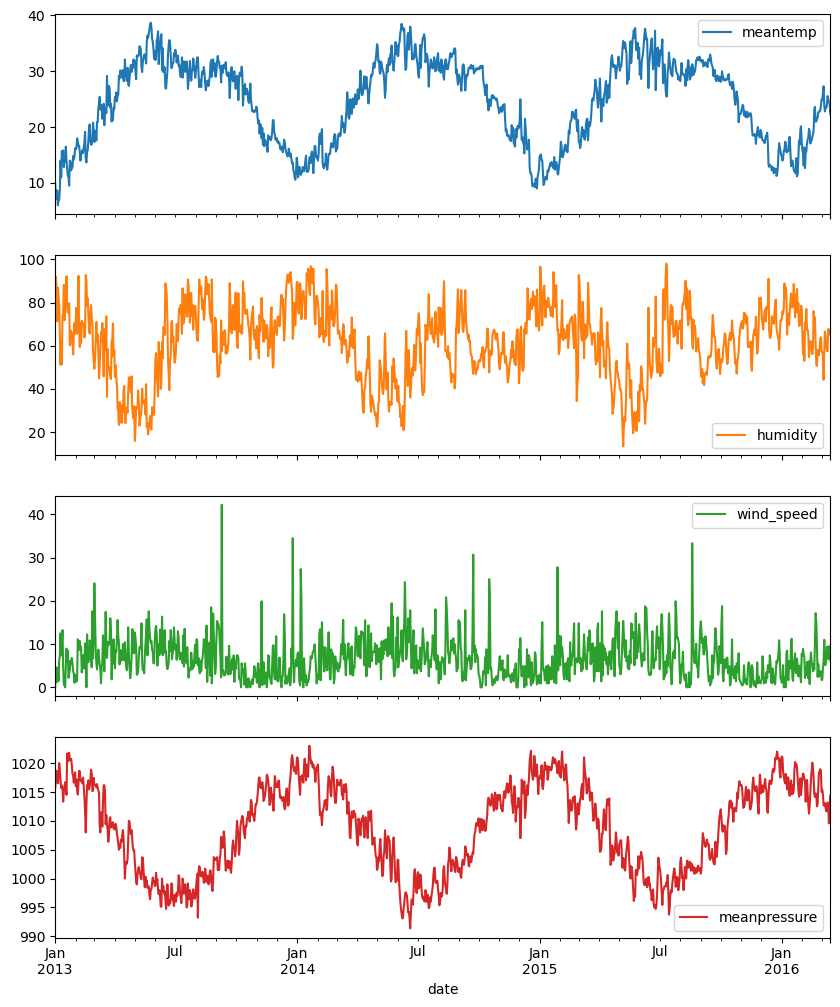

In [26]:
df_train.plot(subplots=True, figsize=(10, 12))

In [38]:
from sklearn.metrics import mean_squared_error

def print_errors(y_train, y_fit, y_test, y_pred):
    error = pd.DataFrame(columns=['Train RMSE', 'Test RMSE'], index= y_train.columns)
    for col in y_train:
        error.loc[col, 'Train RMSE'] = mean_squared_error(y_train[col], y_fit[col], squared=False)
        error.loc[col, 'Test RMSE'] = mean_squared_error(y_test[col], y_pred[col], squared=False)
    display(error)

In [42]:
y = df_train.copy()
dp = DeterministicProcess(
    index=y.index,  # dates from the training data
    constant=True,  # the intercept
    order=1,        # linear trend
    drop=True,      # drop terms to avoid collinearity
)
X = dp.in_sample()  # features for the training data

idx_train, idx_test = train_test_split(
    y.index, test_size=0.2, shuffle=False,
)
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

# Fit trend model
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

# Make predictions
y_fit = pd.DataFrame(
    model.predict(X_train),
    index=y_train.index,
    columns=y_train.columns,
)
y_pred = pd.DataFrame(
    model.predict(X_test),
    index=y_test.index,
    columns=y_test.columns,
)

# Plot
axs = y_train.plot(color='0.25', subplots=True, sharex=True)
axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Trends")

In [39]:
df_tr

NameError: name 'X_train' is not defined

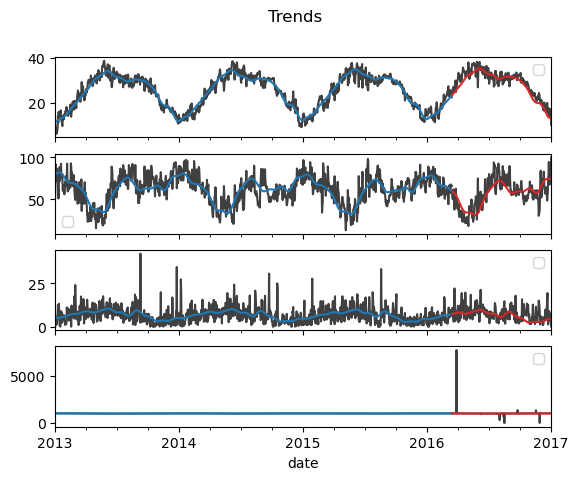

In [45]:
fourier = CalendarFourier(freq='Y', order=10)
dp = DeterministicProcess(
    index=y.index,  # dates from the training data
    constant=True,  # the intercept
    additional_terms=[fourier],
    order=1,        # linear trend
    drop=True,      # drop terms to avoid collinearity
)
X = dp.in_sample()  # features for the training data

idx_train, idx_test = train_test_split(
    y.index, test_size=0.2, shuffle=False,
)
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

# Fit trend model
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

# Make predictions
y_fit = pd.DataFrame(
    model.predict(X_train),
    index=y_train.index,
    columns=y_train.columns,
)
y_pred = pd.DataFrame(
    model.predict(X_test),
    index=y_test.index,
    columns=y_test.columns,
)

# Plot
axs = y_train.plot(color='0.25', subplots=True, sharex=True)
axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Trends")

In [47]:
print_errors(y_train, y_fit, y_test, y_pred)

,Train RMSE,Test RMSE
meantemp,2.072097,2.416018
humidity,10.481356,10.948852
wind_speed,4.189316,4.202887
meanpressure,2.241475,401.997759


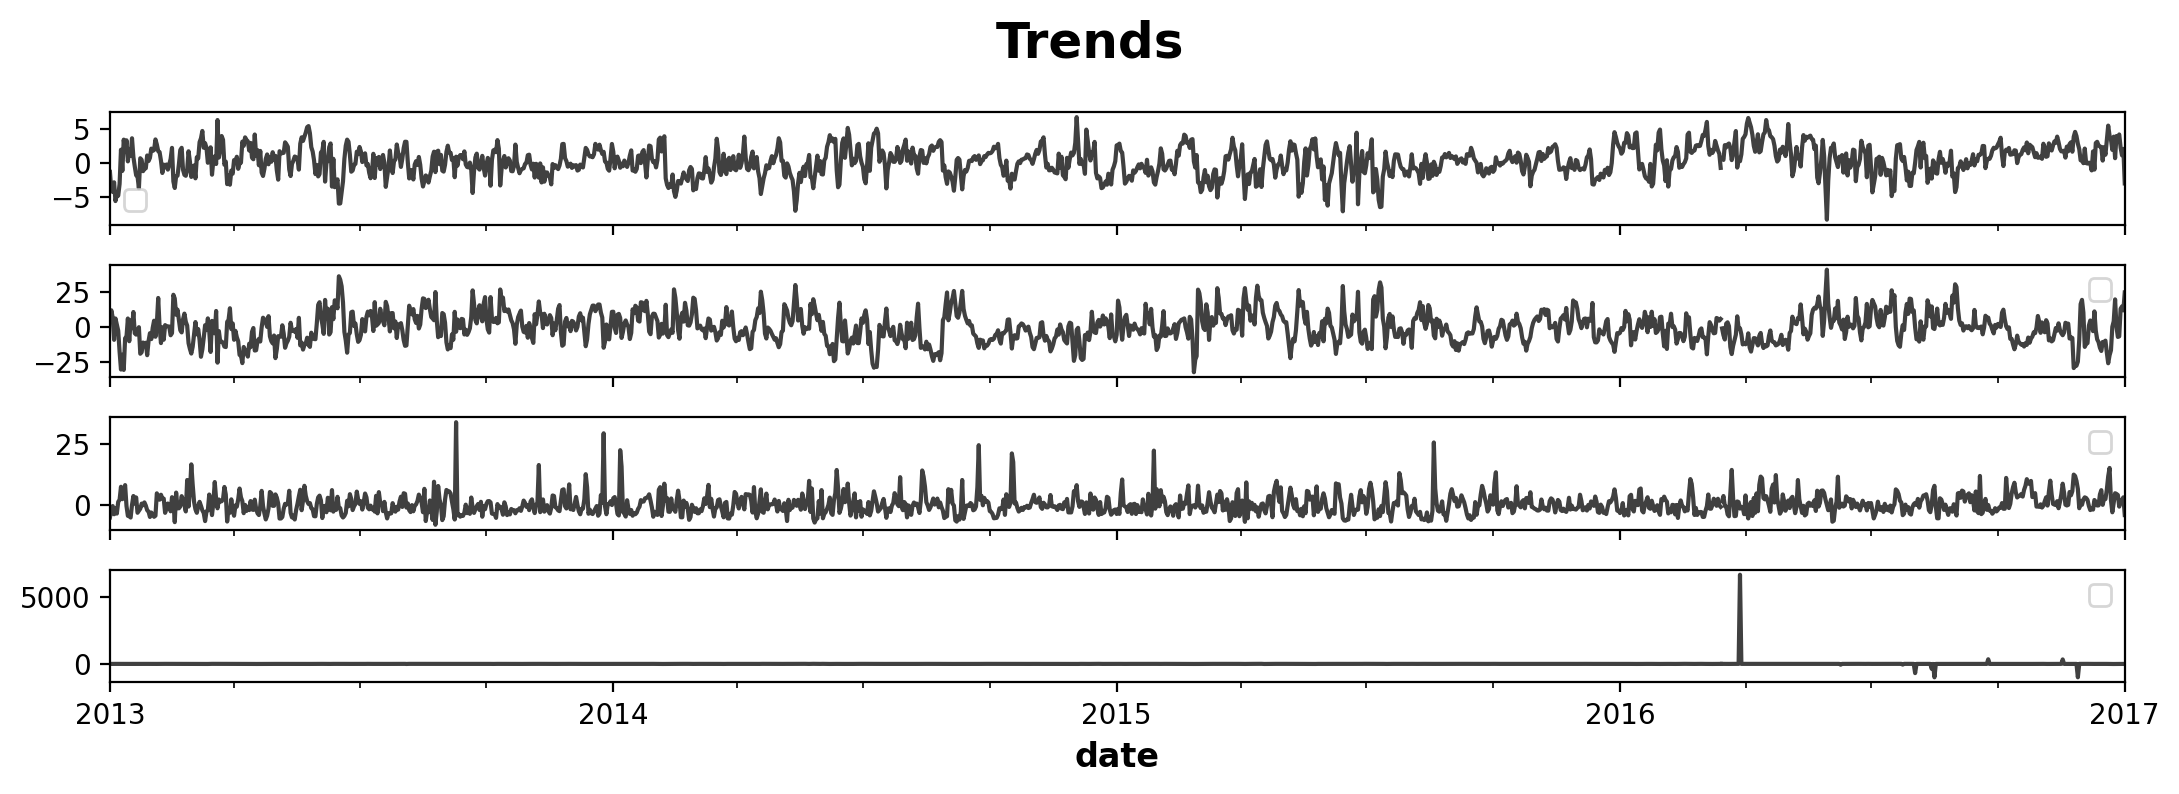

In [56]:

y_res_train = y_train - y_fit
y_res_test = y_test - y_pred
axs = y_res_train.plot(color='0.25', subplots=True, sharex=True)
axs = y_res_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Trends")

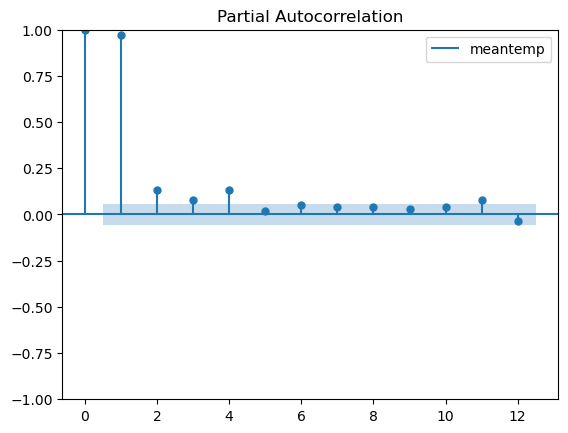

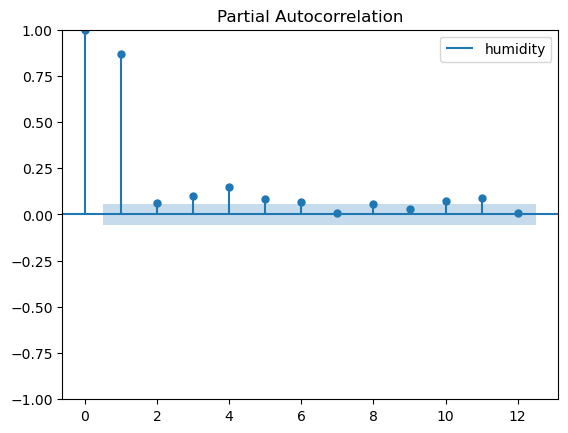

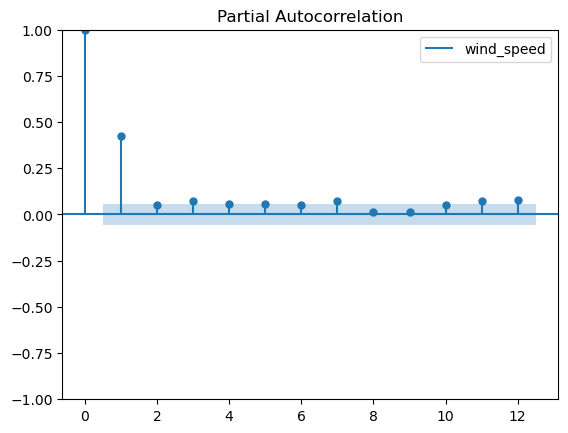

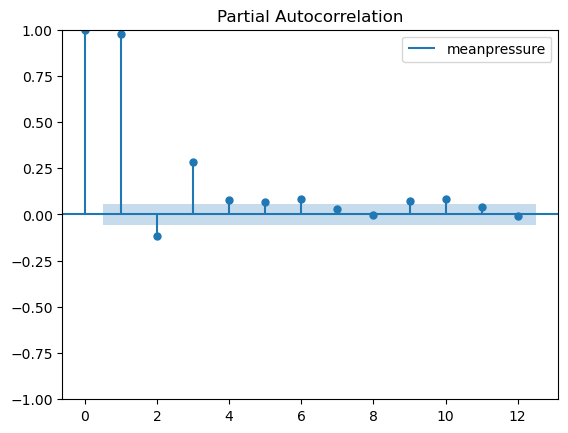

In [70]:
for col in y_train.columns:
    plot_pacf(y_train[col], lags=12)
    plt.legend([col])

In [89]:
class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None

    def fit(self, X_1, X_2, y):
        self.model_1.fit(X_1, y)

        y_fit = pd.DataFrame(
            self.model_1.predict(X_1),
            index=X_1.index, columns=y.columns,
        )

        y_resid = y - y_fit
        y_resid = y_resid.stack().squeeze()

        self.model_2.fit(X_2, y_resid)

        self.y_columns = y.columns
        self.y_fit = y_fit
        self.y_resid = y_resid

    def predict(self, X_1, X_2):
        y_pred = pd.DataFrame(
            self.model_1.predict(X_1),
            index=X_1.index, columns=self.y_columns,
        )
        y_pred = y_pred.stack().squeeze()

        y_pred += self.model_2.predict(X_2)
        
        return y_pred.unstack()


In [91]:
fourier = CalendarFourier(freq='Y', order=10)
dp = DeterministicProcess(
    index=y.index, 
    constant=True, 
    additional_terms=[fourier],
    order=1, 
    drop=True)
X_1 = dp.in_sample()

In [93]:
X_2 = y.stack()

In [ ]:
for col in y_train.columns:
    plt.plot(y_train[col].shift(1), y_train['meantemp'].shift(1))
    plt.show()